Per il riconoscimento facciale abbiamo bisogno di seguire i passi indicati nel paper firmato da Turk e Pentland:
- Aquisire un dataset di facce
- Calcolare le eigenfaces dal set di apprendimento conservando solo le M immagini che hanno gli autovalori più alti. Queste M facce rappresentano lo spazio delle facce, questo spazio può essere man mano aggiornato
- Calcolare la distribuzione M dimensionale per ogni individuo proiettando la faccia sullo spazio delle facce

Una volta inizializzato il sistema, possiamo procedere in questo modo:
- Calcolare un set di pesi in base all'immagine fornita e gli autovalori proiettando l'immagine su ogni eigenfaces 
- Determinare se l'immagine è effettivamente un volto controllando che sia abbastanza vicino allo spazio delle facce
- Calcolare i pesi in modo da definire se è una persona che è già segnata o meno
- Opzionalmente si possono aggiornare pesi e spazio delle facce 

In [5]:
import os
import glob 
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

In [6]:
faces_xml = 'haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier()
if not face_cascade.load(faces_xml):
    print('--(!)Error loading face cascade')
    exit(0)


root = "foto64x64"
cwd = os.getcwd()
listDir = os.listdir(root)
tagFoto = {}

for dir in listDir:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFoto[dir] = imgs


In [7]:
def violajones(im):
    img = cv2.imread(im,0)
    faceROI = np.zeros((64,64), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(64,64), interpolation=cv2.INTER_LINEAR)
        
    return faceROI

In [8]:
faceMean = np.zeros((64,64), dtype=np.float32)
faceNumber = 0
listOfArray = []
faceLabel = []

for key in tagFoto:
    for im in tagFoto[key]:
        vj = violajones(im)
        faceMean += vj
        flat = vj.flat
        listOfArray.append(flat)
        faceLabel.append(key)
        faceNumber+=1

faceMean /= faceNumber

#faceMean = faceMean.astype(np.uint8)
MatrixFlattenedImages = np.vstack(listOfArray)  
flattenFaceMean = faceMean.flatten()

In [9]:
pca = PCA().fit(MatrixFlattenedImages)


with open('pca.pkl', 'wb') as pickle_file:
        pickle.dump(pca, pickle_file)

In [10]:
with open('pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)

n_components = 4096
eigenfaces = pca.components_[:n_components]
weights = eigenfaces @ (MatrixFlattenedImages - pca.mean_).T


In [ ]:

vj = violajones("test/0.jpg")
query = vj.reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print(f"Approssimazione migliore {faceLabel[best_match]}  \n Distanza euclidea {euclidean_distance[best_match]} ")
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(64,64), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(MatrixFlattenedImages[best_match].reshape(64,64), cmap="gray")
axes[1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")
plt.show()


In [24]:
def violajonesMultiple(img):
    faceROI = np.zeros((64,64), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    listOfFaceROI = []
    pos =[]
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(64,64), interpolation=cv2.INTER_LINEAR)
        listOfFaceROI.append(faceROI)
        pos.append(cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 4))
    return listOfFaceROI, pos

def findCorrespondence(frame):
    vjMul, pos = violajonesMultiple(frame)
    print(f"trovati {len(vjMul)} volti nel frame")
    for vj in vjMul:
        query = vj.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
        best_match = np.argmin(euclidean_distance)
        print(f"Approssimazione migliore {faceLabel[best_match]}  \n Distanza euclidea {euclidean_distance[best_match]} ")
        fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
        axes[0].imshow(query.reshape(64,64), cmap="gray")
        axes[0].set_title("Query")
        axes[1].imshow(MatrixFlattenedImages[best_match].reshape(64,64), cmap="gray")
        axes[1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")
        plt.show()
        
    cv2.imshow("face detect", sum(pos))
    cv2.waitKey(0)
    cv2.destroyAllWindows()



trovati 2 volti nel frame
Approssimazione migliore Larry_Thompson  
 Distanza euclidea 2397.117431640625 


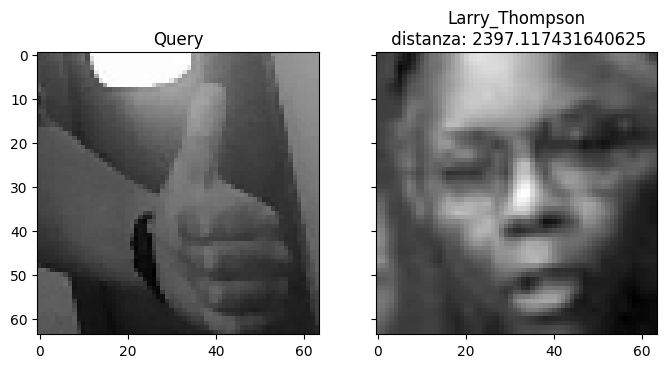

Approssimazione migliore Kim_Dong-hwa  
 Distanza euclidea 1752.905517578125 


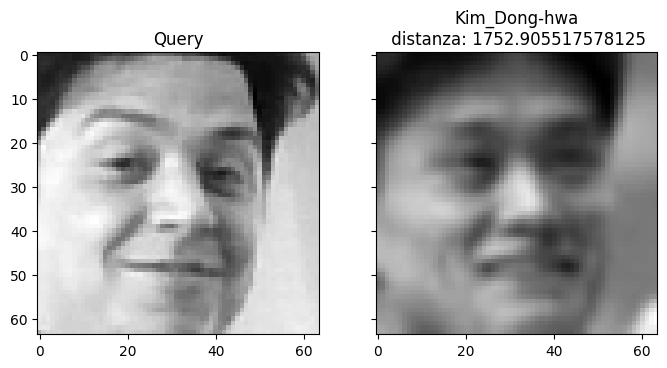

In [26]:
img = cv2.imread("test/0.jpg",0)

findCorrespondence(img)